In [74]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects

# conda install ipywidgets for movie 
from ipywidgets import interact, FloatSlider, IntSlider

In [75]:
%matplotlib inline

## 1. Background notes on "Emergent properties of collective gene-expression patterns in multicellular systems"
Smart, M., & Zilman, A. (2023). [Paper Link](https://doi.org/10.1016/j.xcrp.2023.101247)
### 1.1 Single-cell model
Assume cell state is described by the activity of $N$ genes in the cell. Let $\xi_1, \ldots, \xi_N$ denotes the desired cell types, with $\xi_i\in\{1,-1\}^N$. 
Let $\hat{J}=\xi(\xi^{T}\xi)^{-1}\xi^T$ represent the gene-gene interactions. 
First, we want to show that $\xi_i$ is the eigenvector of matrix $\hat{J}$. That is to show that $$\hat{J}\xi_i=\lambda_i\xi_i.$$
* Let $A=(\xi^{T}\xi)^{-1}\xi^T$. Note that 
$$A\xi=(\xi^{T}\xi)^{-1}\xi^T\xi=I.$$
* This implies the following,
\begin{align*}
\hat{J}\xi&=\xi A \xi\\
&=\xi I\\
&=I\xi.
\end{align*}
Therefore, $\xi_i$ are eigenvectors of matrix $\hat{J}$ for the repeated eigenvalue $\lambda=1$.


* Next, to get the final gene-gene interaction matrix J, the authors set the diagonal value to zero. That is,
$$\hat J_0=\hat J - \text{diag}(\hat J).$$

# Focus: single-cell model - linear algebra and rules
Stemming from discussion of these ingredients:  
1) We have a desired $N \times p$ pattern matrix $\xi$ with $p$ linearly independent patterns in $[-1,1]^N$ stored as columns.
2) One can store the patterns as global minima of the spin hamiltonian given by the quadratic form $H(s)=-\frac{1}{2} s^T J s$ using Hopfield-like constructions for $J$.
3) We have focused on the pseudo-inverse rule $\hat J$ (see below) and the hollowed variant $\hat J_0 = \hat J - \text{diag}(\hat J)$.

Based on intuition from low-dimensional (low $p$, low $N$) cases, we wonder if given an arbitrary $J_{ij}$ matrix one can infer or simply constrain the local minima directly via a rule on the elements of each row.

Side notes: 
- Look for literature on perturbations to $\hat J$ which simplify it (e.g. set elements below a threshold magnitude to zero) while preserving pattern storage.

Lingering questions:
- Assuming all entries of matrix $\hat J$ are the same, hollowing transformation won't change the eigenspace of the matrix. But, is it guaranteed all diagonal entries are the same? In any case, note that the diagonal elements contribute a constant $\sum_i J_{ii}$ to the energy function since, for any state $s$, we have $s_i^2=1 \:\: \forall \: i$.  

# Look at examples for small systems (low N, low p)
- we will check spin flip lemma vs numeric energy difference when flipping site k of an arbitrary configuration $s$
- we will consider pathological cases as well where two or more patterns differ by a single flip

In [116]:
import numpy as np
import random
from numpy.linalg import inv
from scipy.stats import bernoulli
from numpy import linalg as LA

N = 9  # number of genes
num_states = 2 ** N  # number of unique binary states for N genes
assert N <= 12   # parts of code below assume 4 genes; TODO: generalize

# Construct the gene-gene interaction matrix J
#xi1 = np.array([-1,1,-1,1,1])  # nov.26
#xi2 = np.array([-1,1,1,1,-1])  # nov.26

xi1 = np.array([ 1, 1, 1, -1,-1,-1, -1,-1,-1])
xi2 = np.array([-1,-1,-1,  1, 1, 1, -1,-1,-1])
xi3 = np.array([-1,-1,-1, -1,-1,-1,  1, 1, 1])

assert len(xi1) == N
xi = np.stack((xi1, xi2), axis=-1)
Jhat = xi @ inv(xi.T @ xi) @ xi.T
Jhat_hollow = Jhat - np.diag(np.diag(Jhat))
print('example evec:', Jhat @ xi2)

example evec: [-1. -1. -1.  1.  1.  1. -1. -1. -1.]


### Single Cell Hamiltonian
$\mathcal{H}(s)= -\frac12(s^TJs) - h^Ts$

In [117]:
# Generate all possible states of the cell and verify the lowest energy state in a single cell
xn = xi1.shape[0]
comb = np.tile([-1,1], (xn, 1)).tolist()
S = np.stack(np.meshgrid(*comb), -1).reshape(-1, xn).T
H = np.diag(-S.T @ Jhat_hollow @ S/2)
ind_xi = np.where(abs(H - H.min())<1e-6)[0]
print("The energy for all cell states are\n", np.round(H,2))
print("The lowest energy states in a single cell are the column vectors of matrix:\n", S[:, ind_xi])
print("The global minimum are cell states with ID:", ind_xi)

ind_glob_max = np.where(abs(H - H.max())<1e-6)[0]
print("The global maximum are cell states with ID:", ind_glob_max)

ind_neighb = [sum(abs(np.tile(S[:,i], (num_states, 1)).T - S)) == 2 for i in range(num_states)]
local_min = np.array([sum((H[i]-1e-6)<=H[ind_neighb[i]]) for i in range(num_states)])
print("The local minimum are cell states with ID:", np.where(local_min==N)[0])

local_max = np.array([sum((H[i]+1e-6)>=H[ind_neighb[i]]) for i in range(num_states)])
print("The local maximum are cell states with ID:", np.where(local_max==N)[0])

The energy for all cell states are
 [-0.5   0.83  0.83  0.83  0.83  0.83  0.83 -0.5  -0.83  0.5   0.5   0.5
  0.5   0.5   0.5  -0.83 -0.83  0.5   0.5   0.5   0.5   0.5   0.5  -0.83
 -1.83 -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -1.83 -0.83  0.5   0.5   0.5
  0.5   0.5   0.5  -0.83 -1.83 -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -1.83
 -1.83 -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -1.83 -3.5  -2.17 -2.17 -2.17
 -2.17 -2.17 -2.17 -3.5  -0.83  0.5   0.5   0.5   0.5   0.5   0.5  -0.83
 -0.5   0.83  0.83  0.83  0.83  0.83  0.83 -0.5  -0.5   0.83  0.83  0.83
  0.83  0.83  0.83 -0.5  -0.83  0.5   0.5   0.5   0.5   0.5   0.5  -0.83
 -0.5   0.83  0.83  0.83  0.83  0.83  0.83 -0.5  -0.83  0.5   0.5   0.5
  0.5   0.5   0.5  -0.83 -0.83  0.5   0.5   0.5   0.5   0.5   0.5  -0.83
 -1.83 -0.5  -0.5  -0.5  -0.5  -0.5  -0.5  -1.83 -0.83  0.5   0.5   0.5
  0.5   0.5   0.5  -0.83 -0.5   0.83  0.83  0.83  0.83  0.83  0.83 -0.5
 -0.5   0.83  0.83  0.83  0.83  0.83  0.83 -0.5  -0.83  0.5   0.5   0.5
  0.5   0.5   0.5  -0

Text(0, 0.5, '$H_i$')

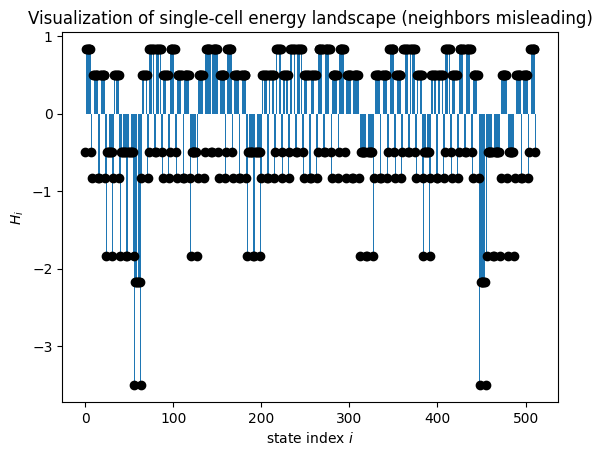

In [115]:
plt.bar(np.arange(num_states), height=H)
plt.plot(H, 'ok')
plt.title('Visualization of single-cell energy landscape (neighbors misleading)')
plt.xlabel(r'state index $i$')
plt.ylabel(r'$H_i$')

## Tool: Given a state, flip all $k=1,...,N$ spins and compare (A) numeric energy change vs (B) lemma energy change $\Delta H = 2 s_k (h_k - J_{kk})$ for $h_k = \sum_j J_{ij} s_j$ 

In [80]:
def hamiltonian_quadform(J, s_vec):
    return 0.5 * s_vec.T @ J @ s_vec

def compare_spinflip_numeric_vs_lemma(J, s_vec):
    N = len(s_vec)
    h_vec = np.dot(J, s_vec)
    
    energy_0 = hamiltonian_quadform(J, s_vec)
    
    energydiff_numeric = np.zeros(N)
    energydiff_lemma = 2 * s_vec * (h_vec - np.diag(J))  # note the - np.diag(J) generalizes the lemma to the case that J is not hollow
    
    for k in range(N):
        s_vec_perturb = np.copy(s_vec)
        s_vec_perturb[k] = -1 * s_vec[k]
        energydiff_numeric[k] = energy_0 - hamiltonian_quadform(J, s_vec_perturb)
        
    return energydiff_numeric, energydiff_lemma

Compare energy diff for flip each of k spins: J = proj rule, s = [1. 1. 1. 1. 1. 1. 1. 1. 1.]
	site 0, -0.333 vs -0.333
	site 1, -0.333 vs -0.333
	site 2, -0.333 vs -0.333
	site 3, -0.333 vs -0.333
	site 4, -0.333 vs -0.333
	site 5, -0.333 vs -0.333
	site 6, 1.333 vs 1.333
	site 7, 1.333 vs 1.333
	site 8, 1.333 vs 1.333
Compare energy diff for flip each of k spins: J = hollowed proj rule, s = [1. 1. 1. 1. 1. 1. 1. 1. 1.]
	site 0, -0.333 vs -0.333
	site 1, -0.333 vs -0.333
	site 2, -0.333 vs -0.333
	site 3, -0.333 vs -0.333
	site 4, -0.333 vs -0.333
	site 5, -0.333 vs -0.333
	site 6, 1.333 vs 1.333
	site 7, 1.333 vs 1.333
	site 8, 1.333 vs 1.333


<Figure size 640x480 with 0 Axes>

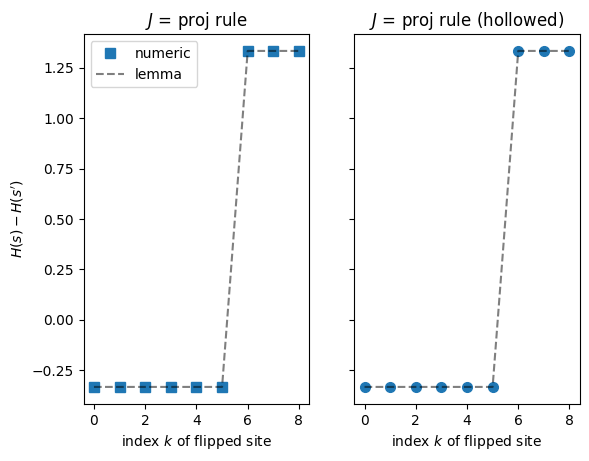

In [112]:
s_choice = np.ones(N)

print('Compare energy diff for flip each of k spins: J = proj rule, s =', s_choice)
energydiff_num, energydiff_lemma = compare_spinflip_numeric_vs_lemma(Jhat, s_choice)
for i in range(N):
    print('\tsite %d, %.3f vs %.3f' % (i, energydiff_num[i], energydiff_lemma[i]))
    
print('Compare energy diff for flip each of k spins: J = hollowed proj rule, s =', s_choice)
energydiff_0_num, energydiff_0_lemma = compare_spinflip_numeric_vs_lemma(Jhat_hollow, s_choice)
for i in range(N):
    print('\tsite %d, %.3f vs %.3f' % (i, energydiff_0_num[i], energydiff_0_lemma[i]))

alpha = 0.5
plt.clf()
_, axarr = plt.subplots(1,2, squeeze=False, sharey=True)
axarr[0,0].plot(np.arange(N), energydiff_num, linewidth=0, marker='s', markersize=7, label='numeric')
axarr[0,0].plot(np.arange(N), energydiff_lemma, '--', color='k', alpha=0.5, label='lemma')
axarr[0,1].plot(np.arange(N), energydiff_0_num, linewidth=0, marker='o', markersize=7)
axarr[0,1].plot(np.arange(N), energydiff_0_lemma, '--', color='k', alpha=0.5)

axarr[0,0].legend()
axarr[0,0].set_title(r'$J$ = proj rule')
axarr[0,1].set_title(r'$J$ = proj rule (hollowed)')
axarr[0,0].set_xlabel(r'index $k$ of flipped site')
axarr[0,1].set_xlabel(r'index $k$ of flipped site')
axarr[0,0].set_ylabel(r"$H(s) - H(s')$")
plt.show()

## Toy model from overleaf Jan 2023 

In [119]:
N = 3  # number of genes
num_states = 2 ** N  # number of unique binary states for N genes
assert N <= 12   # parts of code below assume 4 genes; TODO: generalize

# Construct the gene-gene interaction matrix J
xi1 = np.array([ 1,-1, 1])
xi2 = np.array([-1,-1, 1])

assert len(xi1) == N
xi = np.stack((xi1, xi2), axis=-1)
Jhat = xi @ inv(xi.T @ xi) @ xi.T
Jhat_hollow = Jhat - np.diag(np.diag(Jhat))
print('example evec:', Jhat @ xi2)

example evec: [-1. -1.  1.]


In [120]:
Jhat

array([[ 1. ,  0. ,  0. ],
       [ 0. ,  0.5, -0.5],
       [ 0. , -0.5,  0.5]])